In [2]:
import cooler 
import cooltools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cooltools.lib.plotting

from coolbox.utilities.genome import GenomeRange
from coolbox.api import *
import re
import sys
sys.path.append("/shareb/zliu/analysis/hires_gastrulation/")
from CHARMtools import structure

In [3]:
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=0)


def kth_diag_indices(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols

In [4]:
celltype = pd.read_csv("/shareb/zliu/analysis/hires_mouse_dev/metadata_qcpass.tsv",sep="\t")
celltype = celltype.query('rmsd_20k < 1.5') #

In [5]:
# set random seed to 42
np.random.seed(42)

celltype1_path = ["/shareb/zliu/analysis/hires_mouse_dev/HiC_clean3/3d_info/cools/"+i+".20k.cool" for i in celltype.query('celltype in ["early neurons"]')["cellname"].values.T]
celltype2_path = ["/shareb/zliu/analysis/hires_mouse_dev/HiC_clean3/3d_info/cools/"+i+".20k.cool" for i in celltype.query('celltype not in ["early neurons"]')["cellname"].values.T]
#sample 300 cells in celltype1_path and celltype2_path
celltype1_path = np.random.choice(celltype1_path,300)
celltype2_path = np.random.choice(celltype2_path,300)

In [6]:
site_bedpe = pd.read_csv("../../figure3_related_new/di_new_emb/alldis.filtered.tsv.gz",sep="\t").query('celltype == "early_neurons"')
#color is #c01834 if diff is positive and #2e3994  if diff is negative
site_bedpe["color"] = site_bedpe["diff"].apply(lambda x: "#c01834" if x < 0 else "#2e3994")
#celltype_select = ["early_neurons","radial_glias","neural_tube","nerual_ectoderm","epiblast_and_PS"]#,"early_mesoderm","early_mesenchyme"]
#site_bedpe_temp = site_bedpe.query('celltype in @celltype_select')
site_bedpe_tmep = site_bedpe[["chrom1","start1","end1","chrom2","start2","end2"]].drop_duplicates()

In [7]:
resolution = 20000

[W::hts_idx_load3] The index file is older than the data file: /share/home/zliu/share/Data/public/ref_genome/mouse_ref/M23/raw_data/M23UCSC_genes_symbol_subset.bed.bgz.tbi
[W::hts_idx_load3] The index file is older than the data file: /share/home/zliu/share/Data/public/ref_genome/mouse_ref/M23/raw_data/M23UCSC_genes_symbol_subset.bed.bgz.tbi


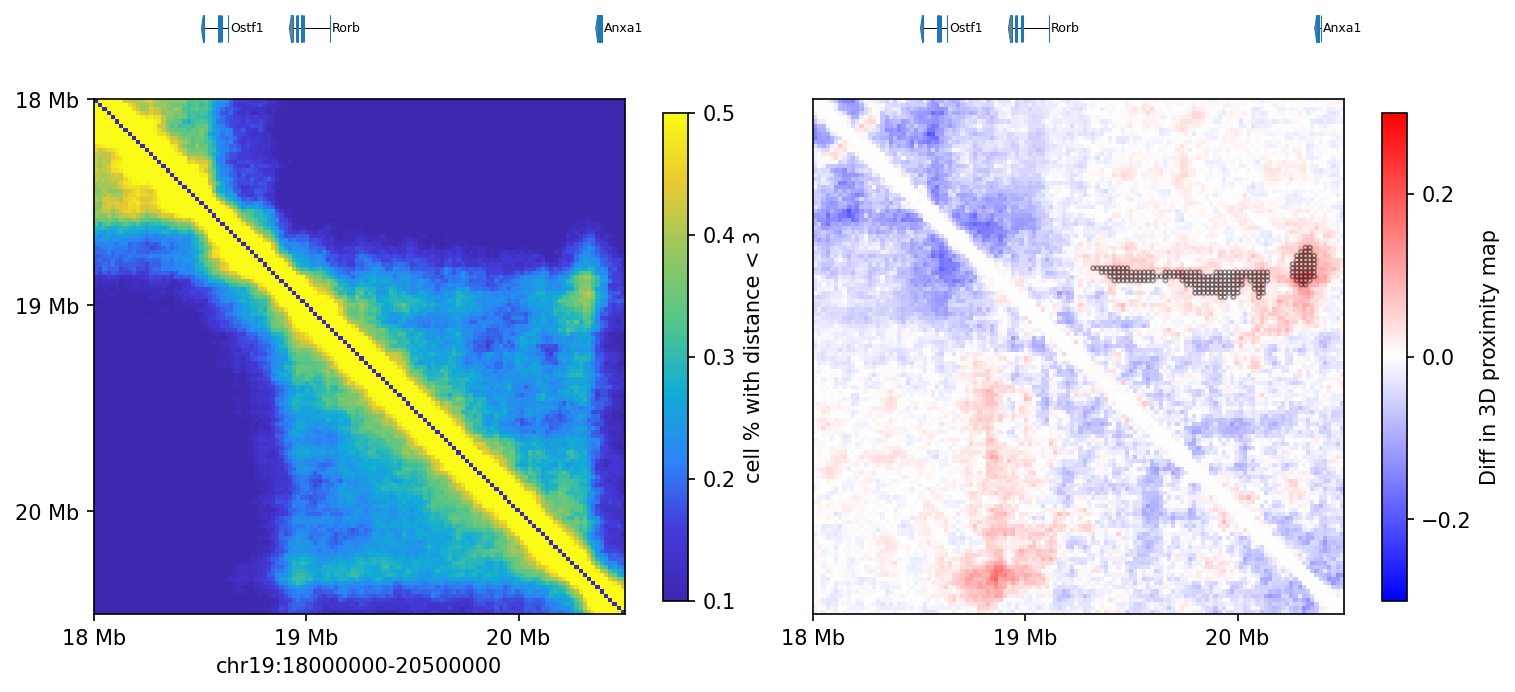

In [22]:
genome_coord = "chr19:18,000,000-20,500000"

vmax1 = 0.5
vmin1 = 0.1

vmax2 = 0.3
vmin2 = -0.3

genome_coord_pat = genome_coord.replace(":","pat:")
genome_coord_mat = genome_coord.replace(":","mat:")
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('mycmap', ["#fafb16","#E8C931","#96C761","#53C689","#12ACD6","#2C84F6","#453AD9","#3d28af"][::-1])

#定义bed文件的地址
raw_bed = "/share/home/zliu/share/Data/public/ref_genome/mouse_ref/M23/raw_data/M23UCSC_genes_symbol_subset.bed"

matpercent1= structure.get3dProximityStackMatrix(celltype1_path,genome_coord1=genome_coord) #+ structure.get3dProximityStackMatrix(celltype1_path,genome_coord1=genome_coord_mat)
matpercent2 = structure.get3dProximityStackMatrix(celltype2_path,genome_coord1=genome_coord) #+ structure.get3dProximityStackMatrix(celltype2_path,genome_coord1=genome_coord_mat)

normal_mat=np.triu(matpercent1)+np.tril(matpercent2)
#右下角的矩阵
diff_mat=matpercent1 - matpercent2


#对坐标做一些处理
genome_coord = genome_coord.replace(",","")
genome_coord_split=re.split(string = genome_coord, pattern = "[:-]")
genome_coord_split[1] = int(genome_coord_split[1])#起点
genome_coord_split[2] = int(genome_coord_split[2])#终点
genome_length = genome_coord_split[2] - genome_coord_split[1]#基因的长度
start_cor=genome_coord_split[1]
gr = GenomeRange(genome_coord)


#创建画布
f, ax = plt.subplots(ncols=2,nrows=2,
        figsize=(10,4.5),dpi=150
        ,sharex='col'
        # ,sharey='row'
        ,constrained_layout=True,gridspec_kw={'height_ratios': [0.5,4]}
    )

gtfframe = BED(raw_bed
            ,gene_style='flybase'
            ,height=0.01
            ,fontsize=6
            ,num_rows=1
            )
ax0 = gtfframe.plot(ax[0,1],gr=GenomeRange(genome_coord)) 
ax0 = gtfframe.plot(ax[0,0],gr=GenomeRange(genome_coord)) 
#ax[1,0].axis('off')
ax[0,0].axis('off')
ax[0,1].axis('off')
#ax[0,0].axis('off')


ax1 = ax[-1,0]
im = ax[-1,0].matshow(
    normal_mat,cmap=cmap,vmax = vmax1, vmin=vmin1,extent = [gr.start,gr.end,gr.end,gr.start],
    interpolation='nearest', aspect='auto'
);
#添加渐变条
cb = plt.colorbar(im, ax=ax[-1,0] ,fraction=0.046, pad=0.04, label='cell % with distance < 3');
cb.ax.locator_params(nbins = 5)
format_ticks(ax1)

ax1.locator_params(axis='both', nbins=4)
ax1.set(xlabel=genome_coord)

#【右下】
ax2 = ax[-1,1]
#标记【特定的点（原来黑色的区域）】

im2 = ax[-1,1].matshow(diff_mat
                        ,cmap="bwr",vmax = vmax2, vmin= vmin2
                    ,extent = [gr.start,gr.end,gr.end,gr.start]
                    ,interpolation='nearest', aspect='auto'

                    );


ax[-1,1].get_shared_y_axes().join(ax[-1,0], ax[-1,1])
ax[-1,1].set_yticks([])


#添加颜色bar
cb = plt.colorbar(im2, ax=ax[-1,1] ,fraction=0.046, pad=0.04, label='Diff in 3D proximity map');
cb.ax.locator_params(nbins = 5)
#设置刻度格式
format_ticks(ax2)
ax2.locator_params(axis='both', nbins=4)

if site_bedpe is not None:
     for site in site_bedpe.query('chrom1 == @genome_coord_split[0] & start1 > @genome_coord_split[1] & end1 < @genome_coord_split[2] & chrom2 == @genome_coord_split[0] & start2 > @genome_coord_split[1] & end2 < @genome_coord_split[2]').values.tolist():
         ax2.add_artist(plt.Circle(((site[4]+site[5])/2,(site[1]+site[2])/2),radius=0.5*resolution,color="black",alpha=0.4,fill=False,linewidth=0.8))
         #ax2.add_artist(plt.Rectangle(((site[4]+site[5])/2,(site[1]+site[2])/2),width=1*resolution,height = 1*resolution,color="black",alpha=0.4,fill=True,linewidth=0))
    
    

In [ ]:
f.savefig("Rorb.pdf",dpi=150)

In [7]:
resolution= 20000
# load matrix file
#genome_coord="chr7:18,000,000-20,000,000".replace(",","")
genome_coord = "chr18:70000000-73800000"
#genome_coord = "chr18:"
genome_coord_pat = genome_coord.replace(":","pat:")
genome_coord_mat = genome_coord.replace(":","mat:")
gr = GenomeRange(genome_coord)


normal_mat = np.mean([structure.get3dProximityStackMatrix(celltype1_path,genome_coord1=genome_coord_pat),
                structure.get3dProximityStackMatrix(celltype1_path,genome_coord1=genome_coord_mat)],axis=0)


genome_coord = genome_coord.replace(",","")
genome_coord_split=re.split(string = genome_coord, pattern = "[:-]")
genome_coord_split[1] = int(genome_coord_split[1])
genome_coord_split[2] = int(genome_coord_split[2])
genome_length = genome_coord_split[2] - genome_coord_split[1]

# range start from 100 since we only calculate interactions within 2mb
for i in range(int(2000000/resolution), normal_mat.shape[0]):
    #print(i)
    normal_mat[kth_diag_indices(normal_mat,i)] = 1000
    normal_mat[kth_diag_indices(normal_mat,-i)] = 1000


In [10]:
# create custom matplotlib colormap with #2b1c79 #5799ae #ceaf49 #f3fd48
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('mycmap', ["#fafb16","#E8C931","#96C761","#53C689","#12ACD6","#2C84F6","#453AD9","#3d28af"])


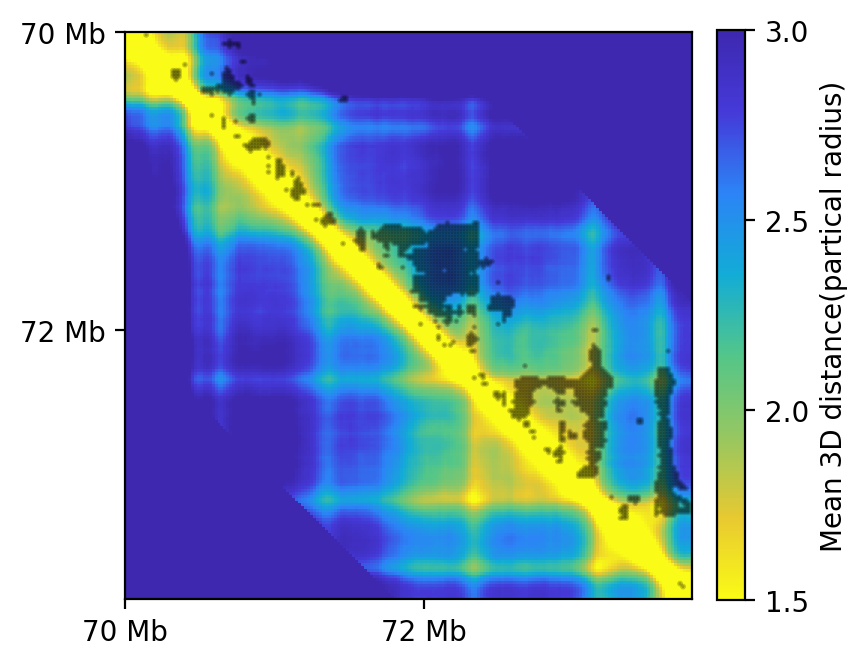

In [11]:
f, ax = plt.subplots(ncols=1,nrows=1,
    figsize=(4,4),dpi=200,#sharex='col',sharey='row',constrained_layout=True,gridspec_kw={'height_ratios': [1,4]}
    )

im = ax.matshow(
        normal_mat,cmap=cmap,vmax = 3, vmin=1.5,extent = [gr.start,gr.end,gr.end,gr.start],
        #interpolation='nearest', aspect='auto'
);

cb = plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='Mean 3D distance(partical radius)');
cb.ax.locator_params(nbins = 5)
format_ticks(ax)


for site in site_bedpe_tmep.query('chrom1 == @genome_coord_split[0] & start1 > @genome_coord_split[1] & end1 < @genome_coord_split[2] & chrom2 == @genome_coord_split[0] & start2 > @genome_coord_split[1] & end2 < @genome_coord_split[2]').values.tolist():
            ax.add_artist(plt.Circle(((site[4]+site[5])/2,(site[1]+site[2])/2),radius=0.5*resolution,color="black",alpha=0.2,fill=True,linewidth=1))

ax.locator_params(axis='both', nbins=2)

In [117]:
# save figure in cmyk  and use white as background
#plt.savefig("chr18_70M_74M_20k.pdf",format="pdf",transparent=True,facecolor="white",edgecolor="white")

f.savefig("Dcc_topdi.svg",bbox_inches='tight',cmyk=True,facecolor="white")

In [13]:
celltype1_path = ["/shareb/zliu/analysis/hires_mouse_dev/figure3_related/d3d_res_analysis/obs_exp/cools_distance/"+i+".distance.20k.cool" for i in celltype.query('celltype in ["mix late mesenchyme"] & cellcycle_threshold == "G0"')["cellname"].values.T]

In [14]:
#chr8:35,800,000-38,500,000
resolution= 20000
# load matrix file
#genome_coord="chr7:18,000,000-20,000,000".replace(",","")
genome_coord = "chr8:35800000-38500000"
#genome_coord = "chr18:"
genome_coord_pat = genome_coord.replace(":","pat:")
genome_coord_mat = genome_coord.replace(":","mat:")
gr = GenomeRange(genome_coord)


normal_mat = np.mean([structure.get3dProximityStackMatrix(celltype1_path,genome_coord1=genome_coord_pat),
                structure.get3dProximityStackMatrix(celltype1_path,genome_coord1=genome_coord_mat)],axis=0)


genome_coord = genome_coord.replace(",","")
genome_coord_split=re.split(string = genome_coord, pattern = "[:-]")
genome_coord_split[1] = int(genome_coord_split[1])
genome_coord_split[2] = int(genome_coord_split[2])
genome_length = genome_coord_split[2] - genome_coord_split[1]

# range start from 100 since we only calculate interactions within 2mb
for i in range(int(2000000/resolution), normal_mat.shape[0]):
    #print(i)
    normal_mat[kth_diag_indices(normal_mat,i)] = 1000
    normal_mat[kth_diag_indices(normal_mat,-i)] = 1000

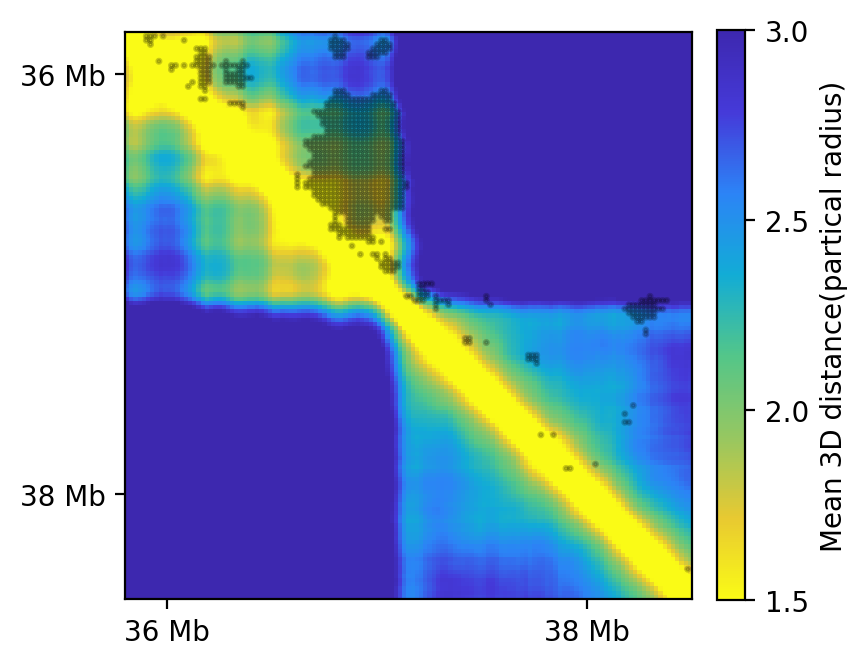

In [15]:
f, ax = plt.subplots(ncols=1,nrows=1,
    figsize=(4,4),dpi=200,#sharex='col',sharey='row',constrained_layout=True,gridspec_kw={'height_ratios': [1,4]}
    )

im = ax.matshow(
        normal_mat,cmap=cmap,vmax = 3, vmin=1.5,extent = [gr.start,gr.end,gr.end,gr.start],
        #interpolation='nearest', aspect='auto'
);

cb = plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='Mean 3D distance(partical radius)');
cb.ax.locator_params(nbins = 5)
format_ticks(ax)


for site in site_bedpe_tmep.query('chrom1 == @genome_coord_split[0] & start1 > @genome_coord_split[1] & end1 < @genome_coord_split[2] & chrom2 == @genome_coord_split[0] & start2 > @genome_coord_split[1] & end2 < @genome_coord_split[2]').values.tolist():
            ax.add_artist(plt.Circle(((site[4]+site[5])/2,(site[1]+site[2])/2),radius=0.5*resolution,color="black",alpha=0.2,fill=True,linewidth=1))

ax.locator_params(axis='both', nbins=2)